# Routines for extracting the geometries of tracks (angle, length)

In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
from analysis_funcs import *

In [3]:
def extract_track(obs, ii):
    """
    Extract and reshape a track from TrackObs obs at index ii.
    Output track is in units of electrons
    """
    return np.reshape(obs.data[ii]["TRACK"],(obs.data[ii]["DIM_AL"],obs.data[ii]["DIM_AC"]))*obs.gain

In [4]:
### Routines using Hough transformation

def unbin(track, fac_AL, fac_AC):
    """
    Resample the track onto a grid of quadratic pixels.
    fac_AL and fac_AC relate the length of AL and AC samples to 10 um 
    (so usually fac_AL = bin_AL, fac_AC = 3*bin_AC)
    """
    outimg = np.zeros((track.shape[0]*fac_AL, track.shape[1]*fac_AC))
    rescale = track/(fac_AL * fac_AC)
    
    for iAL in range(track.shape[0]):
        for iAC in range(track.shape[1]):
            if rescale[iAL,iAC] != 0:
                outimg[iAL*fac_AL:(iAL+1)*fac_AL, iAC*fac_AC:(iAC+1)*fac_AC] = rescale[iAL,iAC]
    return outimg

def get_angle_hough(unbinned):
    from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)

    h, th, d = hough_line(unbinned)
    theta = hough_line_peaks(h, th, d)[1][0] # this should be chosen differently
    #return theta
    return hough_line_peaks(h, th, d)[1]

In [5]:
# Custom routine fitting a line

def linefunc(pars, x):
    """
    pars is an array of [theta,y0], with theta given in degrees
    """
    return np.tan(pars[0]*np.pi/180)*x + pars[1]

# same function, but for scipy.optimize.curve_fit
def linefunc_opt(x,theta,m):
    return np.tan(theta*np.pi/180)*x + m

def angle_linefit(track, pixratio=1):
    """
    Determine the angle of the track with respect to axis 0.
    In case of non-quadratic pixels, pixratio gives the ratio of pixel lengths in axis 1 to axis 0 
    (so in case of Gaia, AC/AL including binnning)
    """
    
    dim0, dim1 = track.shape
    
    # we will form an x/y value pairs, with x being along axis 0, y being along axis 1
    # the values of the longer axis (i.e. more pixels) will just be the pixel coordinates
    # the values of the shorter axis will be the center of mass for each row/column
    
    from scipy.ndimage.measurements import center_of_mass
    
    if dim0 >= dim1:
        labels = np.zeros((dim0,dim1)) + np.transpose(np.array([range(dim0)]))
        cms = (center_of_mass(track, labels, range(dim0)))              
    else:
        labels = np.zeros((dim0,dim1)) + np.array([range(dim1)])
        cms = (center_of_mass(track, labels, range(dim1)))
        
    # set x and y from the centers of mass and subtract offset so the middle value is (0,0)
    x = (np.array([c[0] for c in cms]) - (dim0-1)/2)
    y = (np.array([c[1] for c in cms]) - (dim1-1)/2)* pixratio
    
    # there are sometimes nan values in here due to taking the center of mass over elements that are all 0
    # remove them for now
    nanvals = np.logical_or(np.isnan(x),np.isnan(y))
    if nanvals.any():
        x = x[np.logical_not(nanvals)]
        y = y[np.logical_not(nanvals)]
    
    # TODO erros should be calculated more intelligently
    dx = np.zeros(x.shape)+0.5
    dy = np.zeros(y.shape)+pixratio/2
    
    # Estimation of the angle
    # if one of the dimensions is 1, theta is either 0 or +-90 degrees
    # and the error is just the angle of a diagonal through the extreme points
    if dim1==1:
        # 0 degrees
        theta = 0
        sd_theta = np.arctan(dy[0]/(dim0*dx[0]))*180/np.pi
        
    elif dim0==1:
        # +-90, default to +
        theta = 90
        sd_theta = np.abs(theta-np.arctan((dim1*dy[0])/dx[0])*180/np.pi)
    else:
        # get the theta via a fit
        from scipy import odr

        linemodel = odr.Model(linefunc)

        fitdat = odr.RealData(x, y, sx=dx, sy=dy)

        # give a rough starting value for theta
        thetastart = np.arctan(pixratio*(dim1-1)/(dim0-1))*180/np.pi
        
        myodr = odr.ODR(fitdat, linemodel, beta0=[thetastart, 0.])
        myoutput = myodr.run()
        theta = myoutput.beta[0]
        sd_theta = myoutput.sd_beta[0]

            
    # Estimation of the length
    # if one of the dimensions is 1, the length and it
    if dim1==1:
        # literally just the distance in x
        tracklen=x[-1]-x[0]
        sd_tracklen = np.sqrt(dx[-1]**2+dx[0]**2)
    elif dim0==1:
        # distance in y
        tracklen=y[-1]-y[0]
        sd_tracklen = np.sqrt(dy[-1]**2+dy[0]**2)
    else:
        costheta = np.cos(theta*np.pi/180)
        sintheta = np.sin(theta*np.pi/180)
        # depending on which axis was used to fit, calculate the length differently
        if dim0>=dim1:
            costheta = np.cos(theta*np.pi/180)
            tracklen = (x[-1]-x[0])/costheta
            sd_tracklen = np.sqrt((dx[-1]**2+dx[0]**2)/costheta**2 
                                   +(x[-1]-x[0])**2 * sintheta**2/costheta**6  * (sd_theta*np.pi/180)**2)
        else:
            tracklen = (y[-1]-y[0])/sintheta
            sd_tracklen = np.sqrt((dy[-1]**2+dy[0]**2)/sintheta**2 
                                   +(y[-1]-y[0])**2 * costheta**2/sintheta**6  * (sd_theta*np.pi/180)**2)

            
    return theta, sd_theta, np.abs(tracklen), sd_tracklen

In [6]:
def angle_linefit_show(track, pixratio=1):
    """
    Determine the angle of the track with respect to axis 0.
    In case of non-quadratic pixels, pixratio gives the ratio of pixel lengths in axis 1 to axis 0 
    (so in case of Gaia, AC/AL including binnning)
    """
    
    dim0, dim1 = track.shape
    
    # we will form an x/y value pairs, with x being along axis 0, y being along axis 1
    # the values of the longer axis (i.e. more pixels) will just be the pixel coordinates
    # the values of the shorter axis will be the center of mass for each row/column
    
    from scipy.ndimage.measurements import center_of_mass
    
    if dim0 >= dim1:
        labels = np.zeros((dim0,dim1)) + np.transpose(np.array([range(dim0)]))
        cms = (center_of_mass(track, labels, range(dim0)))
        if dim1==1:
            # add a little scatter to dim1
            yvals = (np.random.random(dim0)-0.5)*0.01
            cms = [(cms[ii][0],yvals[ii]) for ii in range(dim0)]                
    else:
        labels = np.zeros((dim0,dim1)) + np.array([range(dim1)])
        cms = (center_of_mass(track, labels, range(dim1)))
        if dim0==1:
            # add a little scatter to dim0
            xvals = (np.random.random(dim1)-0.5)*0.01
            cms = [(xvals[ii],cms[ii][1]) for ii in range(dim1)]
        
    # set x and y from the centers of mass and subtract offset so the middle value is (0,0)
    x = (np.array([c[0] for c in cms]) - (dim0-1)/2)
    y = (np.array([c[1] for c in cms]) - (dim1-1)/2)* pixratio
    
    # there are sometimes nan values in here due to taking the center of mass over elements that are all 0
    # remove them for now
    nanvals = np.logical_or(np.isnan(x),np.isnan(y))
    if nanvals.any():
        x = x[np.logical_not(nanvals)]
        y = y[np.logical_not(nanvals)]
    
    # TODO erros should be calculated more intelligently
    dx = np.zeros(x.shape)+0.5
    dy = np.zeros(y.shape)+pixratio/2

    # Estimation of the angle
    # if one of the dimensions is 1, theta is either 0 or +-90 degrees
    # and the error is just the angle of a diagonal through the extreme points
    if dim1==1:
        # 0 degrees
        theta = 0
        sd_theta = np.arctan(dy[0]/(dim0*dx[0]))*180/np.pi
        ystart = 0
        
    elif dim0==1:
        # +-90, default to +
        theta = 90
        sd_theta = np.arctan((dim1*dy[0])/dx[0])*180/np.pi
        sd_theta = np.abs(theta-sd_theta)
        ystart = 0
    else:
        # get the theta via a fit

        from scipy import odr

        linemodel = odr.Model(linefunc)

        fitdat = odr.RealData(x, y, sx=dx, sy=dy)

        # give a rough starting value for theta
        thetastart = np.arctan(pixratio*(dim1-1)/(dim0-1))*180/np.pi
        
        myodr = odr.ODR(fitdat, linemodel, beta0=[thetastart, 0.])
        myoutput = myodr.run()
        theta = myoutput.beta[0]
        sd_theta = myoutput.sd_beta[0]
        ystart = myoutput.beta[1]


            
    # Estimation of the length
    # if one of the dimensions is 1, the length and it
    if dim1==1:
        # literally just the distance in x
        tracklen=x[-1]-x[0]
        sd_tracklen = np.sqrt(dx[-1]**2+dx[0]**2)
    elif dim0==1:
        # distance in y
        tracklen=y[-1]-y[0]
        sd_tracklen = np.sqrt(dy[-1]**2+dy[0]**2)
    else:
        costheta = np.cos(theta*np.pi/180)
        sintheta = np.sin(theta*np.pi/180)
        # depending on which axis was used to fit, calculate the length differently
        if dim0>=dim1:
            costheta = np.cos(theta*np.pi/180)
            tracklen = (x[-1]-x[0])/costheta
            sd_tracklen = np.sqrt((dx[-1]**2+dx[0]**2)/costheta**2 
                                   +(x[-1]-x[0])**2 * sintheta**2/costheta**6  * (sd_theta*np.pi/180)**2)
        else:
            tracklen = (y[-1]-y[0])/sintheta
            sd_tracklen = np.sqrt((dy[-1]**2+dy[0]**2)/sintheta**2 
                                   +(y[-1]-y[0])**2 * costheta**2/sintheta**6  * (sd_theta*np.pi/180)**2)

    print(theta, sd_theta)
    print(np.abs(tracklen), sd_tracklen)
    
    plt.errorbar(x,y,xerr=dx,yerr=dy,linestyle='')
    plt.plot(x,linefunc((theta,ystart),x))

In [31]:
# SM
obslist = read_Obslist_fits('../output/2016/12/07/SM-SIF_OBMT_START_98084005999790300.fits')
#obslist = read_Obslist_fits('../output/2017/09/10/SM-SIF_OBMT_START_122020498000375100.fits')
bin_AL = 2
bin_AC = 2
pixdepth = 12  # depletion zone depth in mum

# BAM
#obslist = read_Obslist_fits('../analysis/bam/output/2017-07-03/BAM-OBS1_OBMT_START_115999323050548704.fits')
#bin_AL = 1
#bin_AC = 4
#pixdepth = 38  # depletion zone depth in mum

# BAM-SIF
#obslist = read_Obslist_fits('../analysis/bam_sif/output/BAM-SIF1_2014.fits')
#bin_AL = 1
#bin_AC = 4
#pixdepth = 38  # depletion zone depth in mum

print('Nr. Observations:',len(obslist))

Nr. Observations: 150


# single example

In [8]:
longobs = []

for ii in range(len(obslist)):
    if (len(obslist[ii].data) == 0):
        continue
    trackpix = np.array([np.sum(t>0) for t in obslist[ii].data['TRACK']])
    valids = np.max(trackpix)
    if valids >=10:
    #if valids >=40:
        longobs.append(ii)

print('Nr. interesting observations:', len(longobs))

Nr. interesting observations: 500


In [9]:
iobs = longobs[24] # 2 for AL>AC, 

#itrack = np.argmax(np.sqrt((20*obslist[iobs].data['DIM_AL'])**2 + (60*obslist[iobs].data['DIM_AC'])**2))
#itrack = np.argmax(obslist[iobs].data['DIM_AL'])
itrack = np.argmax([np.sum(t>0) for t in obslist[iobs].data['TRACK']])

print("Nr. of samples:",np.sum(obslist[iobs].data[itrack]['TRACK']>0))

Nr. of samples: 45


Track Energy: 77375
Per pixel: 1719.44444444


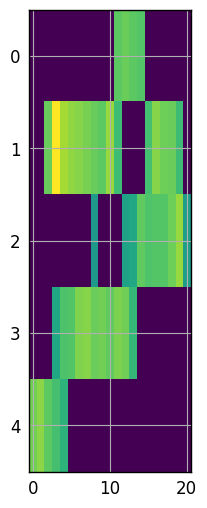

In [10]:
# view the track

track = (extract_track(obslist[iobs], itrack))

#plt.imshow(np.flip(np.rot90(track+1),1), norm=LogNorm())
plt.imshow(np.rot90(track+1), norm=LogNorm(), aspect=3*bin_AC/bin_AL)

print("Track Energy:", obslist[iobs].data[itrack]['TRACK_EN'])
print("Per pixel:", obslist[iobs].data[itrack]['TRACK_EN']/np.sum(obslist[iobs].data[itrack]['TRACK']>0))

40.7371381493 9.43862911071
26.3952705694 5.02980999725


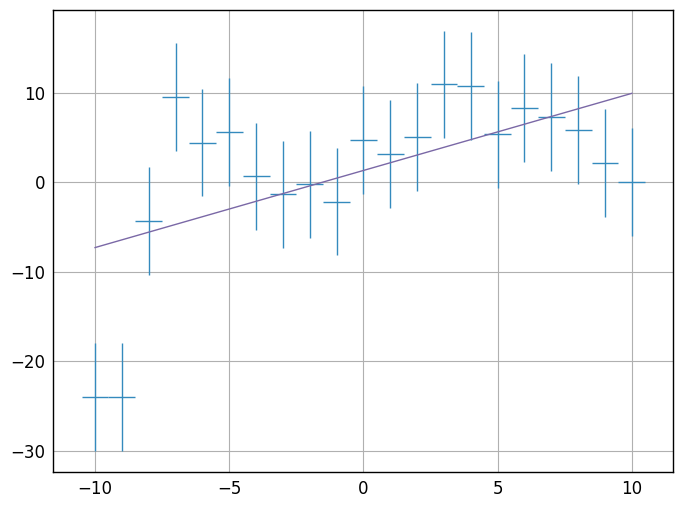

In [11]:
angle_linefit_show(track,3*bin_AC/bin_AL)

# test for everything

In [32]:
theta = []
sd_theta = []
length = []
sd_length = []
energies = []

badtracks = []

#cutoffs = (6,6)

for obs in obslist:   
    for ii in range(len(obs.data)):
        track = extract_track(obs,ii)
        #if np.sum(track>0) < 10 or np.sum(track>0)>1000:
        #if (track.shape[0]<cutoffs[0] and track.shape[1]<cutoffs[1]) or np.sum(track>0)>1000:
        simplen = np.sqrt((track.shape[0]*bin_AL)**2 + (track.shape[1]*3*bin_AC)**2)
        if simplen < 10*bin_AL or np.sum(track>0)>1000:
            continue # too few values to process or an obvious outlier
        """
        theta.append('t')
        """
        ang,sd_ang,l,sd_l = angle_linefit(track,pixratio=3*bin_AC/bin_AL)
        while ang>90:
            ang -= 180
        while ang<-90:
            ang += 180
        theta.append(ang)
        sd_theta.append(sd_ang)
        length.append(l*10*bin_AL)
        sd_length.append(sd_l*10*bin_AL)
        energies.append(obs.data['TRACK_EN'][ii])
        if sd_ang>90:
            badtracks.append(track)
        #"""
        
theta = np.array(theta)
sd_theta = np.array(sd_theta)
length = np.array(length)
sd_length = np.array(sd_length)
energies = np.array(energies)

/home/ckirsch/software/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:1301: RuntimeWarning: invalid value encountered in true_divide
  for dir in range(input.ndim)]


In [68]:
len(theta)

45347

Idea: What happens if you only choose length greater than some value?

# Histograms

(-90, 90)

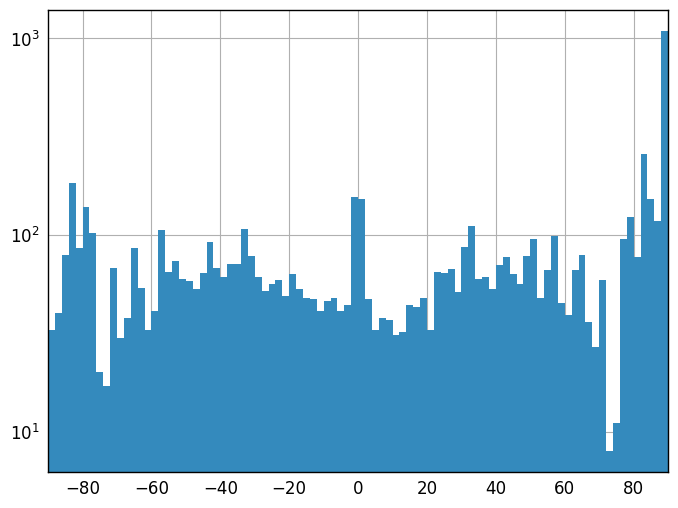

In [36]:
testhist = plt.hist(theta, 90, range=(-90,90),log=True)
plt.xlim(-90,90)
#plt.ylim(0,2000)

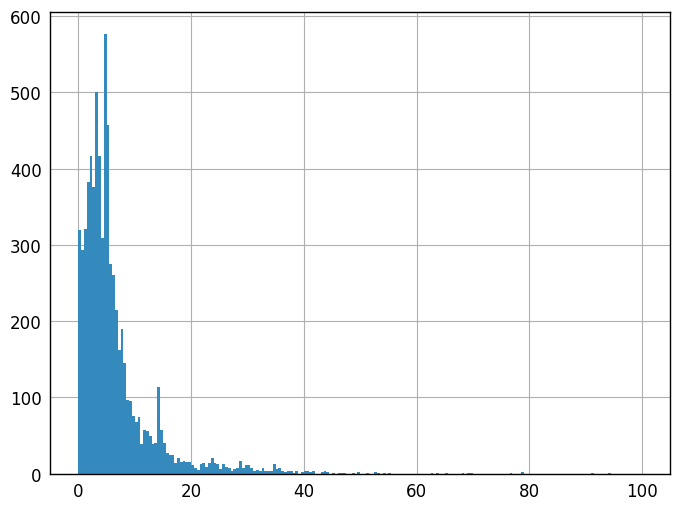

In [37]:
testhist = plt.hist(sd_theta,200,range=(0,100))

Two components here: The high and frequent ones with regular spacing are particles with dim_AC = 1 (manual uncertainty calc.)

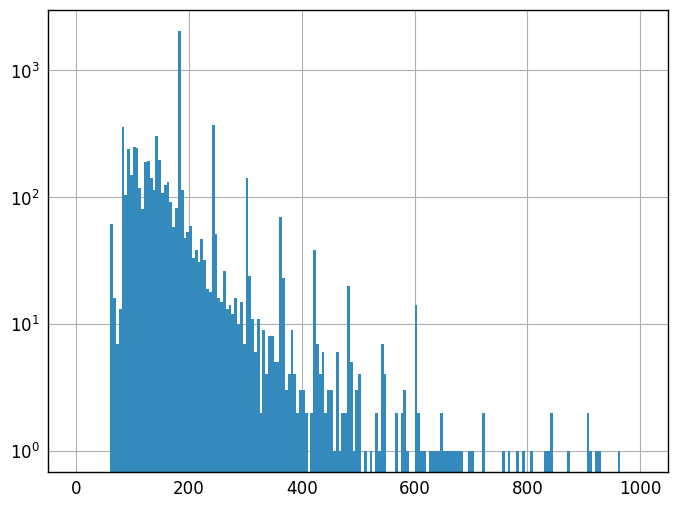

In [38]:
testhist = plt.hist(length, 200,log=True,range=(0,1000))

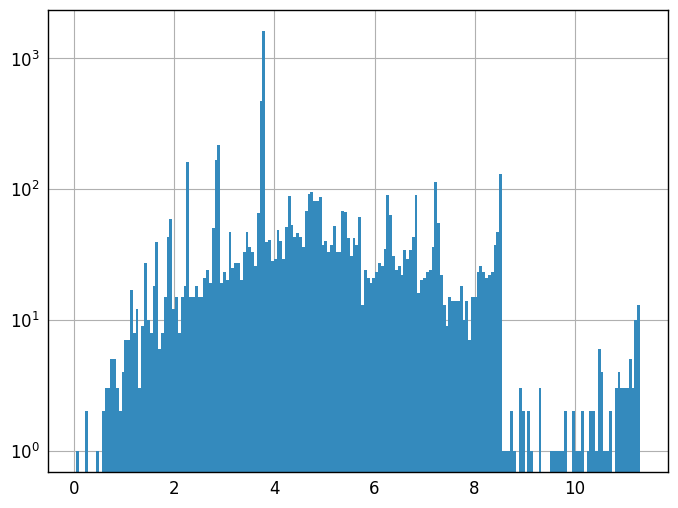

In [39]:
alpha_entr = np.arctan(pixdepth/length)*180/np.pi
athist = plt.hist(alpha_entr, 200,log=True)

# Angular histogram (Nr. of cosmic per angle)

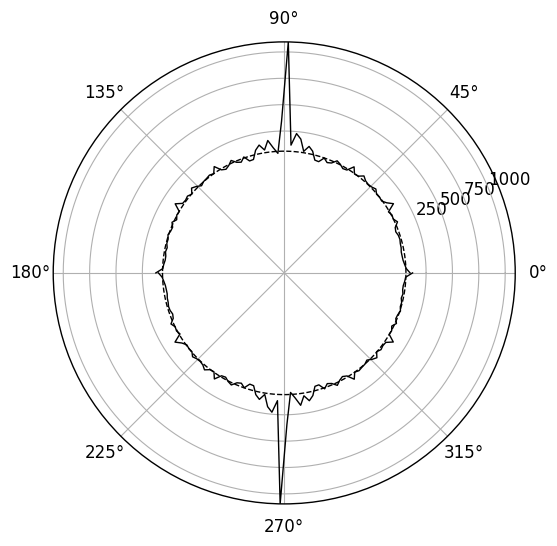

In [40]:
theta_binning = np.copy(theta)
theta_binning[theta<0] += 180
#theta_binning +=sd_theta*(2*np.random.random(theta.shape)-1)

alpha = np.linspace(0,180,90)
radocc = np.zeros(alpha.shape[0])
da = alpha[1]-alpha[0]
bin_lo = alpha-da/2


for ii in range(len(alpha)):
    bin_indices = np.logical_and(theta_binning>=bin_lo[ii], theta_binning<=bin_lo[ii]+da)
    # let's also introduce a length filter
    radocc[ii] = np.sum(np.logical_and(bin_indices,sd_theta>0))

medocc = np.median(radocc)


#radocc *= pixlen  # multiply by the length/pixel in that direction
#medocc *= pixlen  # logic being: the higher pixlen, the harder it is to be detected
                  # although cosmics at that angle may actually excite the "neighbours" of their central pixels...

#radocc = np.log10(radocc)
#medocc = np.log10(medocc)

# set alpha for plotting
alpha = alpha*np.pi/180

for ii in range(2):
    plt.polar(alpha+ii*np.pi, radocc, color='k')
    plt.polar(alpha+ii*np.pi, medocc*np.ones(alpha.shape), color='k', linestyle='--')
    
    
plotrad = np.max(radocc)
plt.xlim((-plotrad,plotrad))
plt.ylim((-plotrad,plotrad))
plt.gca().set_aspect(1)

There are some strange outliers in sd_theta

In [41]:
theta[sd_theta>90]

array([-3.24018886, -9.29280798])

-3.24018885558 91.0320375954
3.00480358776 0.75821023509


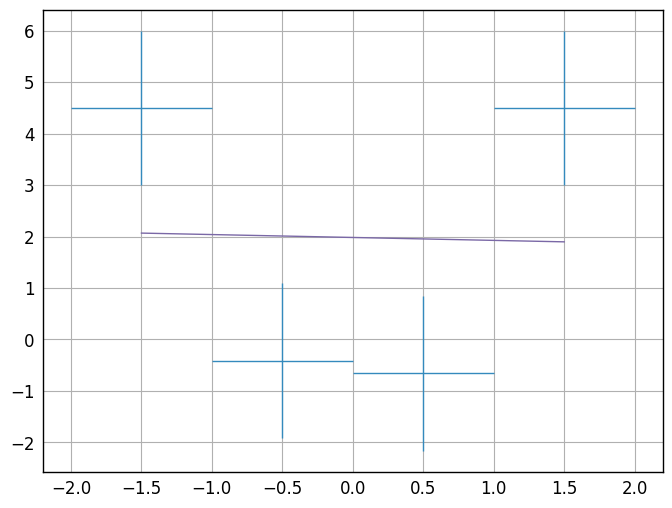

In [42]:
angle_linefit_show(badtracks[0],3*bin_AC/bin_AL)

# Angular length histogram (Lengths per angle)

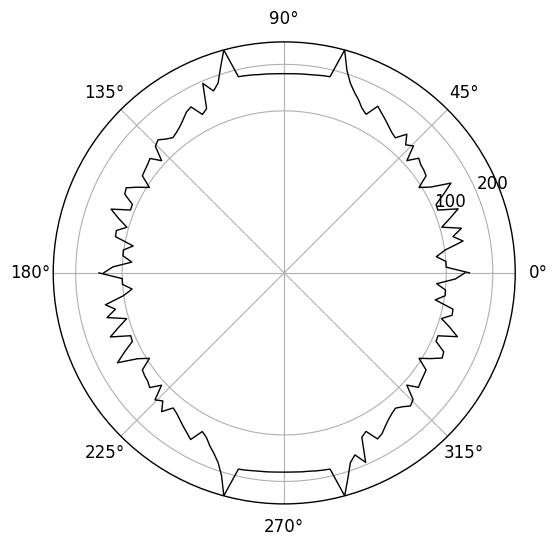

In [43]:
#for ii in range(len(theta)):
#    l = length[ii]
#    th = theta[ii]
#    x = .5*l*np.cos(th/180*np.pi)
#    y = .5*l*np.sin(th/180*np.pi)
#    plt.plot([-x,x],[-y,y])

alpha = np.linspace(0,180,90)
da = alpha[1]-alpha[0]
bin_lo = alpha-da/2

medrad = np.zeros(alpha.shape[0])


for ii in range(len(alpha)):
    bin_indices = np.logical_and(theta_binning>=bin_lo[ii], theta_binning<=bin_lo[ii]+da)
    # let's also introduce a length filter
    medrad[ii] = np.median((length)[np.logical_and(bin_indices,sd_theta>0)])
    # also interesting:
    #medrad[ii] = np.median((length/sd_length)[np.logical_and(bin_indices,length>0)])
    
    
    
#medrad/=pixlen # normalize by length per pixel in that particular direction


# set alpha for plotting
alpha = alpha*np.pi/180
for ii in range(2):
    plt.polar((alpha+ii*np.pi), medrad, color='k')
    

maxrad = np.nanmax(medrad)
minrad = np.nanmin(medrad)

plotrad = np.nanmax(medrad)
plt.xlim((-plotrad,plotrad))
plt.ylim((-plotrad,plotrad))
plt.gca().set_aspect(1)

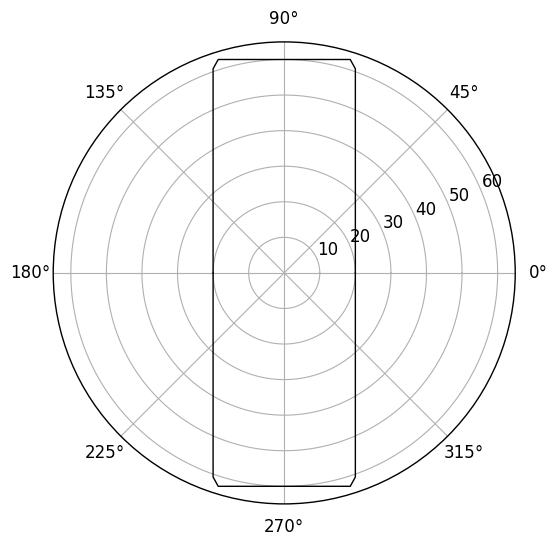

In [50]:
thetacrit = np.arctan(3*bin_AC / (bin_AL))

alpha = np.linspace(0,np.pi,90)

pixlen = np.zeros(alpha.shape)
shortax = np.logical_or(np.abs(alpha)<=thetacrit, np.abs(alpha)>=np.pi-thetacrit)
longax = np.logical_and(np.abs(alpha)>thetacrit, np.abs(alpha)<np.pi-thetacrit)

pixlen[shortax] = 10 * bin_AL / np.cos(np.abs(alpha[shortax]))
pixlen[longax]  = 30 * bin_AC / np.sin(np.abs(alpha[longax]))

pixlen = np.abs(pixlen)


for ii in range(2):
    plt.polar((alpha+ii*np.pi), pixlen, color='k')
    
plt.xlim(-60,60)

... makes sense

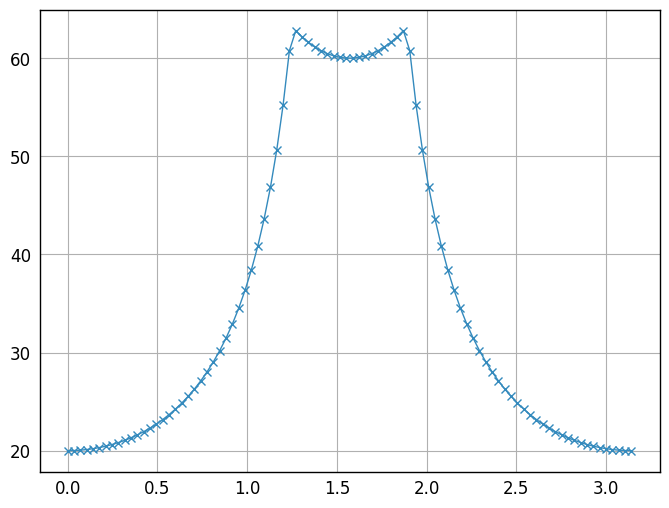

In [51]:
plt.plot(alpha, pixlen, marker='x')

# dE/dx

While histograms over individual tracks don't really give good results, how about just using the average dE/dx?

In [35]:
dEdx = np.array(energies)*3.68/length/100/2.32  # Not using depth here

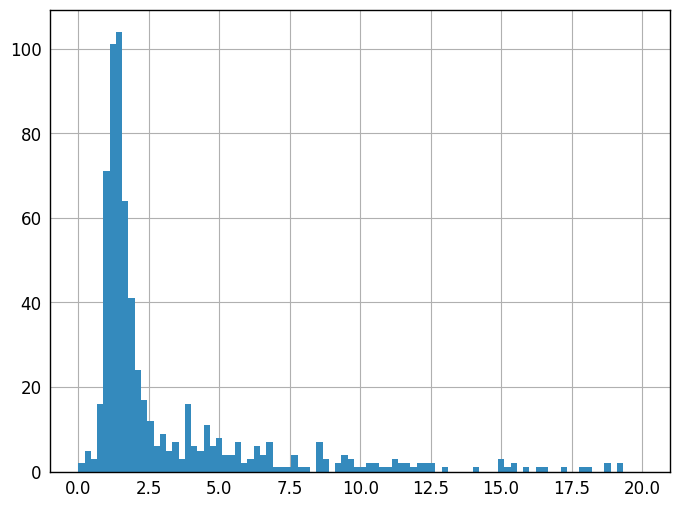

In [34]:
testhist = plt.hist(dEdx[length/sd_length>10],90,log=False,range=(0,20))

-> For SM: During quiescence, there is a single peak at about MIP energy. During the flare however, there is a lot of stuff at a higher dE/dX, as you'd expect from lower energy solar particles!